In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 16.9 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 20.3 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [3]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]1/2 [shap]


In [5]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imblearn]d-learn]


In [49]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd
import h5py
import numpy as np

In [7]:
df = pd.read_csv("feat_engineered_dset.csv", index_col=0)
df.head()

,mean,std,min,q1,median,q3,max,iqr,skew,kurtosis,label
0,1481.250000,1849.612507,0.0,0.0,697.0,2402.25,12522.0,2402.25,1.585470,2.743843,pulsar
1,1478.492222,1848.747699,0.0,0.0,693.0,2411.00,12522.0,2411.00,1.585326,2.739602,pulsar
2,1471.214444,1845.343832,0.0,0.0,678.0,2385.50,12522.0,2385.50,1.597439,2.793968,pulsar
3,1468.466667,1845.243821,0.0,0.0,670.5,2380.50,12522.0,2380.50,1.601142,2.805348,pulsar
4,1466.661667,1843.232127,0.0,0.0,672.5,2358.00,12522.0,2358.00,1.600364,2.798480,pulsar


In [8]:
mapping = dict(enumerate(df['label'].astype('category').cat.categories))
print(mapping)

{0: 'bh', 1: 'pulsar'}


In [9]:
X, y = df.drop(columns=["label"]), df["label"].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class proportions consistent
)


In [10]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [11]:
clf = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",   # fast GPU-like speed on CPU
)


In [12]:
clf.fit(X_train_res, y_train_res)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [13]:
y_pred = clf.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       666
           1       0.99      0.99      0.99      2230

    accuracy                           0.98      2896
   macro avg       0.98      0.98      0.98      2896
weighted avg       0.98      0.98      0.98      2896



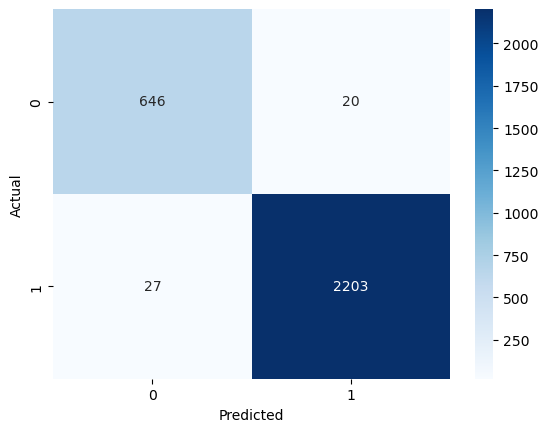

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
# If explainer returns a list (tree models sometimes do)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # use positive class


In [17]:
clf.classes_, mapping

(array([0, 1]), {0: 'bh', 1: 'pulsar'})

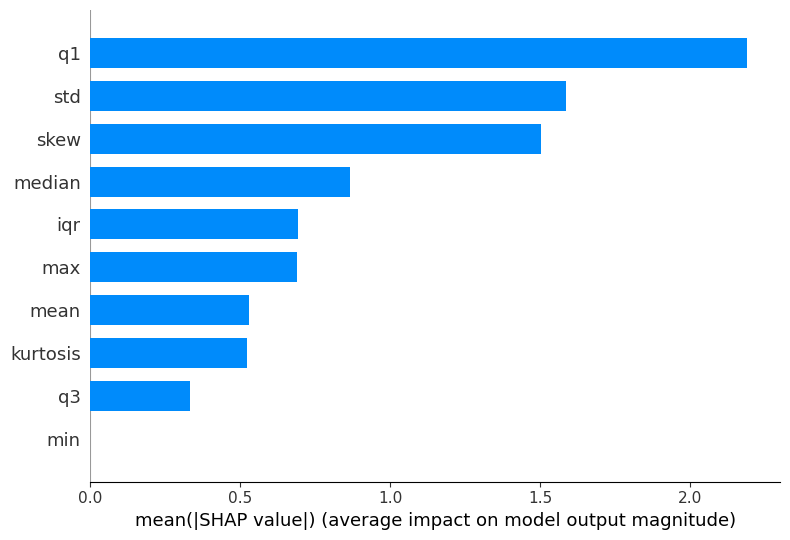

In [18]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


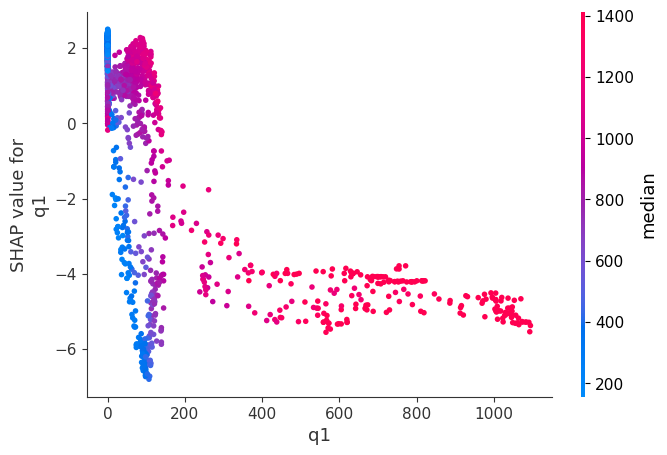

In [19]:
shap.dependence_plot("q1", shap_values, X_test)


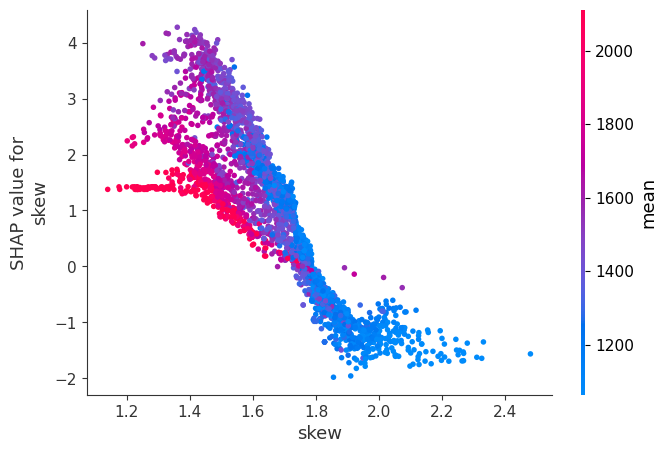

In [20]:
shap.dependence_plot("skew", shap_values, X_test)

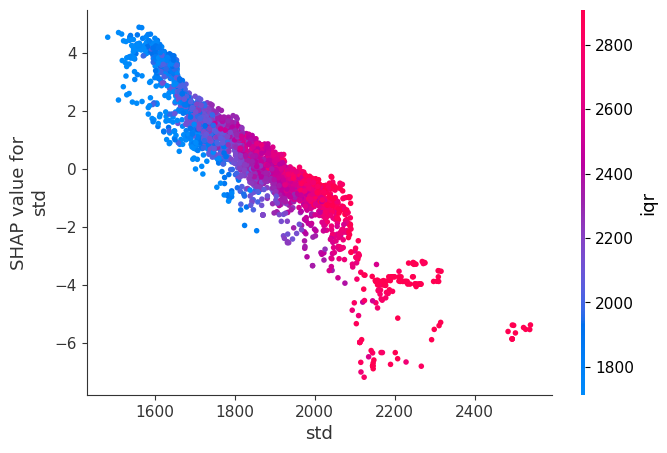

In [21]:
shap.dependence_plot("std", shap_values, X_test)

In [69]:
clf.save_model("xgboost_small.json")

In [23]:
# test on the large dataset from the small dataset

In [45]:
filepath = "/home/idies/workspace/Storage/002375816/persistent/full_1800.h5"

In [64]:
def generate_engineered_dset(filepath, num_rows=None):
    with h5py.File(filepath, "r") as f:
        X_dset = f["phi"]
        y_dset = f["is_pulsar"]
        total_rows = X_dset.shape[0]

        if num_rows is not None:
            idx = np.random.choice(total_rows, size=num_rows, replace=False)
            idx.sort()
        else:
            # take entire dataset
            idx = np.arange(total_rows)

        X = X_dset[idx]
        y = y_dset[idx]

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    X_df = pd.DataFrame(X)
    y_df = pd.DataFrame(y)

    pulsars_df = X_df[(y_df == 1).values]
    bh_df      = X_df[(y_df == 0).values]

    def row_summary_stats(df):
        num_df = df.select_dtypes(include='number')
        summary = pd.DataFrame({
            'mean':     num_df.mean(axis=1),
            'std':      num_df.std(axis=1),
            'min':      num_df.min(axis=1),
            'q1':       num_df.quantile(0.25, axis=1),
            'median':   num_df.quantile(0.50, axis=1),
            'q3':       num_df.quantile(0.75, axis=1),
            'max':      num_df.max(axis=1),
            'iqr':      num_df.quantile(0.75, axis=1) - num_df.quantile(0.25, axis=1),
            'skew':     num_df.skew(axis=1),
            'kurtosis': num_df.kurtosis(axis=1)
        })
        return summary

    p_row_stats = row_summary_stats(pulsars_df)
    bh_row_stats = row_summary_stats(bh_df)
    p_row_stats["label"] = "pulsar"
    bh_row_stats["label"] = "bh"

    return pd.concat([p_row_stats, bh_row_stats]).reset_index(drop=True)

In [85]:
def split_to_X_y(test_df):
    reverse_mapping = {v: k for k, v in mapping.items()}
    return test_df.drop(columns=["label"]), test_df["label"].map(reverse_mapping)

In [86]:
new_test_df = generate_engineered_dset(filepath, 1000)
new_test_df.head()

X shape: (1000, 1800)
y shape: (1000,)


,mean,std,min,q1,median,q3,max,iqr,skew,kurtosis,label
0,3121.383889,2096.996909,291.0,1434.75,2462.0,4457.00,12973.0,3022.25,1.113870,1.055367,pulsar
1,2685.202222,1968.833816,89.0,1255.00,2011.5,3708.50,13509.0,2453.50,1.560743,3.018929,pulsar
2,1953.434444,2189.222208,0.0,0.00,1315.0,3070.25,13360.0,3070.25,1.460642,2.428204,pulsar
3,1107.733333,1625.378916,0.0,0.00,113.0,2007.00,10905.0,2007.00,1.660524,2.675291,pulsar
4,1201.985000,1691.278218,0.0,22.00,253.0,2005.25,12356.0,1983.25,1.767142,3.435548,pulsar


In [87]:
new_test_df['label'].unique()

array(['pulsar', 'bh'], dtype=object)

In [89]:
X_valid, y_valid = split_to_X_y(new_test_df)
y_pred_valid = clf.predict(X_valid)
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       755
           1       0.60      0.52      0.56       245

    accuracy                           0.80      1000
   macro avg       0.72      0.70      0.71      1000
weighted avg       0.79      0.80      0.79      1000

